In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dicom as pdicom
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

from collections import Counter

In [2]:
#list all dicom images
dicom_path = "/home/luk/Desktop/386348/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(dicom_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
            #print(lstFilesDCM)
print(len(lstFilesDCM))

322


In [3]:
RefDs = pdicom.read_file(lstFilesDCM[0])
# print(RefDs)

In [ ]:
arr = []
d = dict()
# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    if "Image" not in filenameDCM:
        continue
    # read the file
    ds = pdicom.read_file(filenameDCM)
    arr.append(ds.pixel_array.shape)
    shape = ds.pixel_array.shape
    if shape in d.keys():
        d[shape].append(filenameDCM)
    else:
        d[shape] = [filenameDCM]

Counter(arr)

In [13]:
# change this to vsualise different dimensions (0,1,..)
dim_id = 0
ArrayDicom = np.zeros((d.keys()[dim_id][0], d.keys()[dim_id][1], len(d[d.keys()[dim_id]])), dtype=RefDs.pixel_array.dtype)

for i, filenameDCM in enumerate(d[d.keys()[dim_id]]):
    ds = pdicom.read_file(filenameDCM) 
    ArrayDicom[:, :, i] = ds.pixel_array 

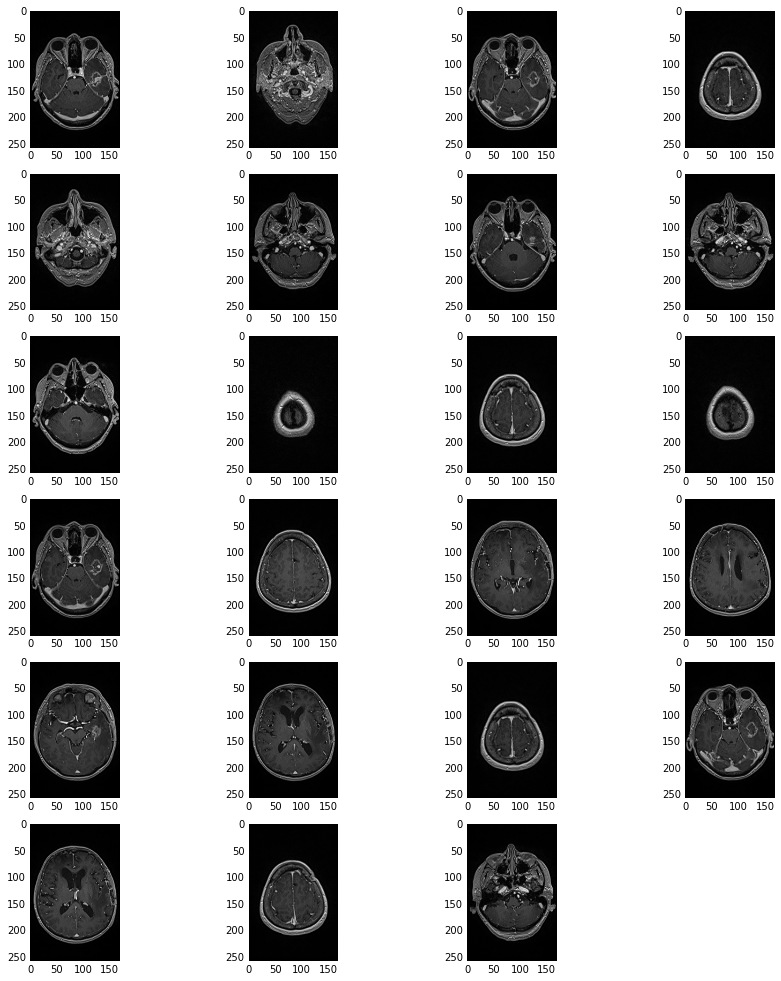

In [14]:
n_slices_to_plot = 23
n_rows = n_slices_to_plot // 4 + 1

plt.set_cmap(plt.gray())
fig = plt.figure(figsize=(15, 17))
for i in range(n_slices_to_plot):
    plt.subplot(n_rows, 4, i + 1)
    plt.imshow(ArrayDicom[:,:,i])
plt.show()